In [1]:
import pandas as pd
import numpy as np
from dscost.pipeline import utils
from dsfunction.resources import load_map
from collections import defaultdict, Counter
import json
import matplotlib.pyplot as plt
from dsfunction.resources import load_map
import scipy.sparse as sparse
from dateutil.relativedelta import relativedelta
from datetime import datetime
from pyspark.sql.types import *
import pyspark.sql.functions as fn
from google.cloud import bigquery
from dateutil import relativedelta
from sklearn.feature_extraction import DictVectorizer
from random import sample
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, auc

In [2]:
sql = SQLContext(sc)
inpath = 'lumiata-internal-6f5a.dwight_multiplan.tbl_202011_CNXNonPar_FinalExtract_V2'
LDM = sql.read.format('bigquery').option('table', inpath).load()
df = LDM.toPandas()

In [3]:
df.shape

(924755, 57)

In [4]:
df.columns

Index(['ClaimID', 'PriorClaimID', 'ClaimType', 'MemberDOB', 'MemberSex',
       'ProductCode', 'BillType', 'ServiceFrom', 'ServiceTo', 'AdmitDate',
       'AdmitType', 'AdmitSource', 'DischargeStatus', 'ProviderID',
       'ProviderOrg', 'ProviderLName', 'ProviderFName', 'ProviderTIN',
       'ProviderNP', 'ProviderState', 'HdrCharges', 'ASOFlag',
       'ContractedFlag', 'PrimaryFlag', 'DRGCode', 'DRGVersion',
       'PrincipalDiag1', 'AdmittingDiag', 'Diag2', 'Diag3', 'Diag4', 'Diag5',
       'Diag6', 'Diag7', 'ICDProc1Princ', 'ICDProc1Date', 'ICDProc2',
       'ICDProc2Date', 'ICDProc3', 'ICDProc3Date', 'ICDProc4', 'ICDProc4Date',
       'LineNumber', 'LineRevCode', 'LinePOS', 'LineProcCode', 'MOD1', 'MOD2',
       'MOD3', 'MOD4', 'LineStartDate', 'LineEndDate', 'LineUnits', 'LineNPI',
       'LineCharges', 'LineNonCovCharges', 'CLAIM_PAR_SCORE'],
      dtype='object')

In [5]:
single_columns = ['PriorClaimID',
 'ClaimType',
 'ProductCode',
 'ProviderID',
 'ProviderNP',
 'ASOFlag',
 'ContractedFlag',
 'PrimaryFlag',
 'DRGVersion',
 'LinePOS',
 'LineNPI']
df = df.drop(columns=single_columns)

In [6]:
df['bday'] = pd.to_datetime(df['MemberDOB'].str[:10], errors='coerce')
now = pd.Timestamp('now')
df['bday'] = pd.to_datetime(df['bday'], format='%m%d%y')    # 1
df['age'] = now.year - df['bday'].dt.year
df['CLAIM_PAR_SCORE'] = pd.to_numeric(df['CLAIM_PAR_SCORE'], errors='coerce')
df['LineUnits'] = pd.to_numeric(df['LineUnits'], errors='coerce')
df['LineNumber'] = pd.to_numeric(df['LineNumber'], errors='coerce')
df['LineCharges'] = pd.to_numeric(df['LineCharges'], errors='coerce')
df['LineNonCovCharges'] = pd.to_numeric(df['LineNonCovCharges'], errors='coerce')
df['HdrCharges'] = pd.to_numeric(df['HdrCharges'], errors='coerce')

In [7]:
need_cols = ['ClaimID', 'MemberSex', 'age','PrincipalDiag1','AdmittingDiag', 'Diag2', 'Diag3', 'Diag4',
'LineRevCode','LineProcCode', 'LineNumber',
'CLAIM_PAR_SCORE']

In [8]:
df = df[need_cols]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924755 entries, 0 to 924754
Data columns (total 12 columns):
ClaimID            924755 non-null object
MemberSex          924755 non-null object
age                924755 non-null int64
PrincipalDiag1     924755 non-null object
AdmittingDiag      924755 non-null object
Diag2              924755 non-null object
Diag3              924755 non-null object
Diag4              924755 non-null object
LineRevCode        924755 non-null object
LineProcCode       924755 non-null object
LineNumber         924755 non-null int64
CLAIM_PAR_SCORE    918108 non-null float64
dtypes: float64(1), int64(2), object(9)
memory usage: 84.7+ MB


In [10]:
dx_claim = defaultdict(dict)

#for col in ['MemberSex', 'age']:
d = dict(zip(df['ClaimID'].values, df['MemberSex'].values))
for cl in d:
    dx_claim[cl]['gender_'+d[cl]] = 1

d = dict(zip(df['ClaimID'].values, df['age'].values))
for cl in d:
    dx_claim[cl]['age'] = d[cl]    

d = dict(zip(df['ClaimID'].values, df['LineNumber'].values))
for cl in d:
    dx_claim[cl]['LineNumber'] = d[cl]      

for col in ['AdmittingDiag', 'Diag2', 'Diag3', 'Diag4']:
    print(col)
    d = dict(zip(df['ClaimID'].values, df[col].values))
    for cl in d:
        if type(d[cl]) == str:
            dx_claim[cl]['diag_'+d[cl]] = 1            

AdmittingDiag
Diag2
Diag3
Diag4


In [11]:
train_keys = sample(list(dx_claim), 200000)
train_dic = {k:dx_claim[k] for k in train_keys}
test_keys = [k for k in dx_claim if k not in train_dic]
print(len(train_keys), len(test_keys))

200000 103652


In [12]:
train_dx = [train_dic[i] for i in train_keys]
test_dx = [dx_claim[i] for i in test_keys]
dv1 = DictVectorizer()
train_mat = dv1.fit_transform(train_dx)
test_mat = dv1.transform(test_dx)
train_mat.shape, test_mat.shape

((200000, 7831), (103652, 7831))

In [13]:
proc_claim = defaultdict(dict)
for col in ['LineProcCode']:
    d = dict(zip(df['ClaimID'].values, df[col].values))
    for cl in d:
        if type(d[cl]) == str:
            proc_claim[cl]['line_proc_'+d[cl]] = 1

In [14]:
train_proc_lst = [proc_claim[i] for i in train_keys]
test_proc_lst = [proc_claim[i] for i in test_keys]
dv2 = DictVectorizer()
train_proc_mat = dv2.fit_transform(train_proc_lst)
test_proc_mat = dv2.transform(test_proc_lst)
train_proc_mat.shape, test_proc_mat.shape

((200000, 2930), (103652, 2930))

In [15]:
rev_claim = defaultdict(dict)
for col in ['LineRevCode']:
    d = dict(zip(df['ClaimID'].values, df[col].values))
    for cl in d:
        if type(d[cl]) == str:
            rev_claim[cl]['line_rev_'+d[cl]] = 1

In [17]:
train_rev_lst = [rev_claim[i] for i in train_keys]
test_rev_lst = [rev_claim[i] for i in test_keys]
dv3 = DictVectorizer()
train_rev_mat = dv3.fit_transform(train_rev_lst)
test_rev_mat = dv3.transform(test_rev_lst)
train_rev_mat.shape, test_rev_mat.shape

((200000, 207), (103652, 207))

In [18]:
train_mat = sparse.hstack((train_mat, train_proc_mat), format='csr')
test_mat = sparse.hstack((test_mat, test_proc_mat), format='csr')
train_mat.shape, test_mat.shape

((200000, 10761), (103652, 10761))

In [19]:
train_mat = sparse.hstack((train_mat, train_rev_mat), format='csr')
test_mat = sparse.hstack((test_mat, test_rev_mat), format='csr')
train_mat.shape, test_mat.shape

((200000, 10968), (103652, 10968))

In [20]:
df_grouped = pd.DataFrame(df.groupby('ClaimID')['CLAIM_PAR_SCORE'].mean()).reset_index()
target = dict(zip(df_grouped['ClaimID'].values, df_grouped['CLAIM_PAR_SCORE'].values))

In [21]:
train_target = [ target[i] for i in train_keys]
test_target = [ target[i] for i in test_keys]

In [23]:
lgb_reg_params = {
    'min_data_in_leaf': 100,
    'num_leaves': 100,
    'min_gain_to_split': 75,
    'sub_feature': 1.0,
    'objective': 'regression',
    'learning_rate': 0.1,
    'num_iterations': 100}

In [24]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_mat, train_target)
reg = lgb.train(lgb_reg_params, lgb_train)

/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [25]:
def feature_rank_plot(model, top_num_feature, feature_lst,
                           importance_type):
    feature_importance = model.feature_importance(importance_type)
    feature_importance = 100.0*(feature_importance/feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    featfig = plt.figure(figsize=(20, 20))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos[-top_num_feature:],
                feature_importance[sorted_idx][-top_num_feature:],
                align='center')
    featax.set_yticks(pos[-top_num_feature:])
    featax.set_yticklabels(
        np.array(feature_lst)[sorted_idx][-top_num_feature:], fontsize=15)
    featax.set_xlabel('relative feature importance', fontsize=15)
    plt.title(type(model).__name__)
    plt.tight_layout()
    plt.show()

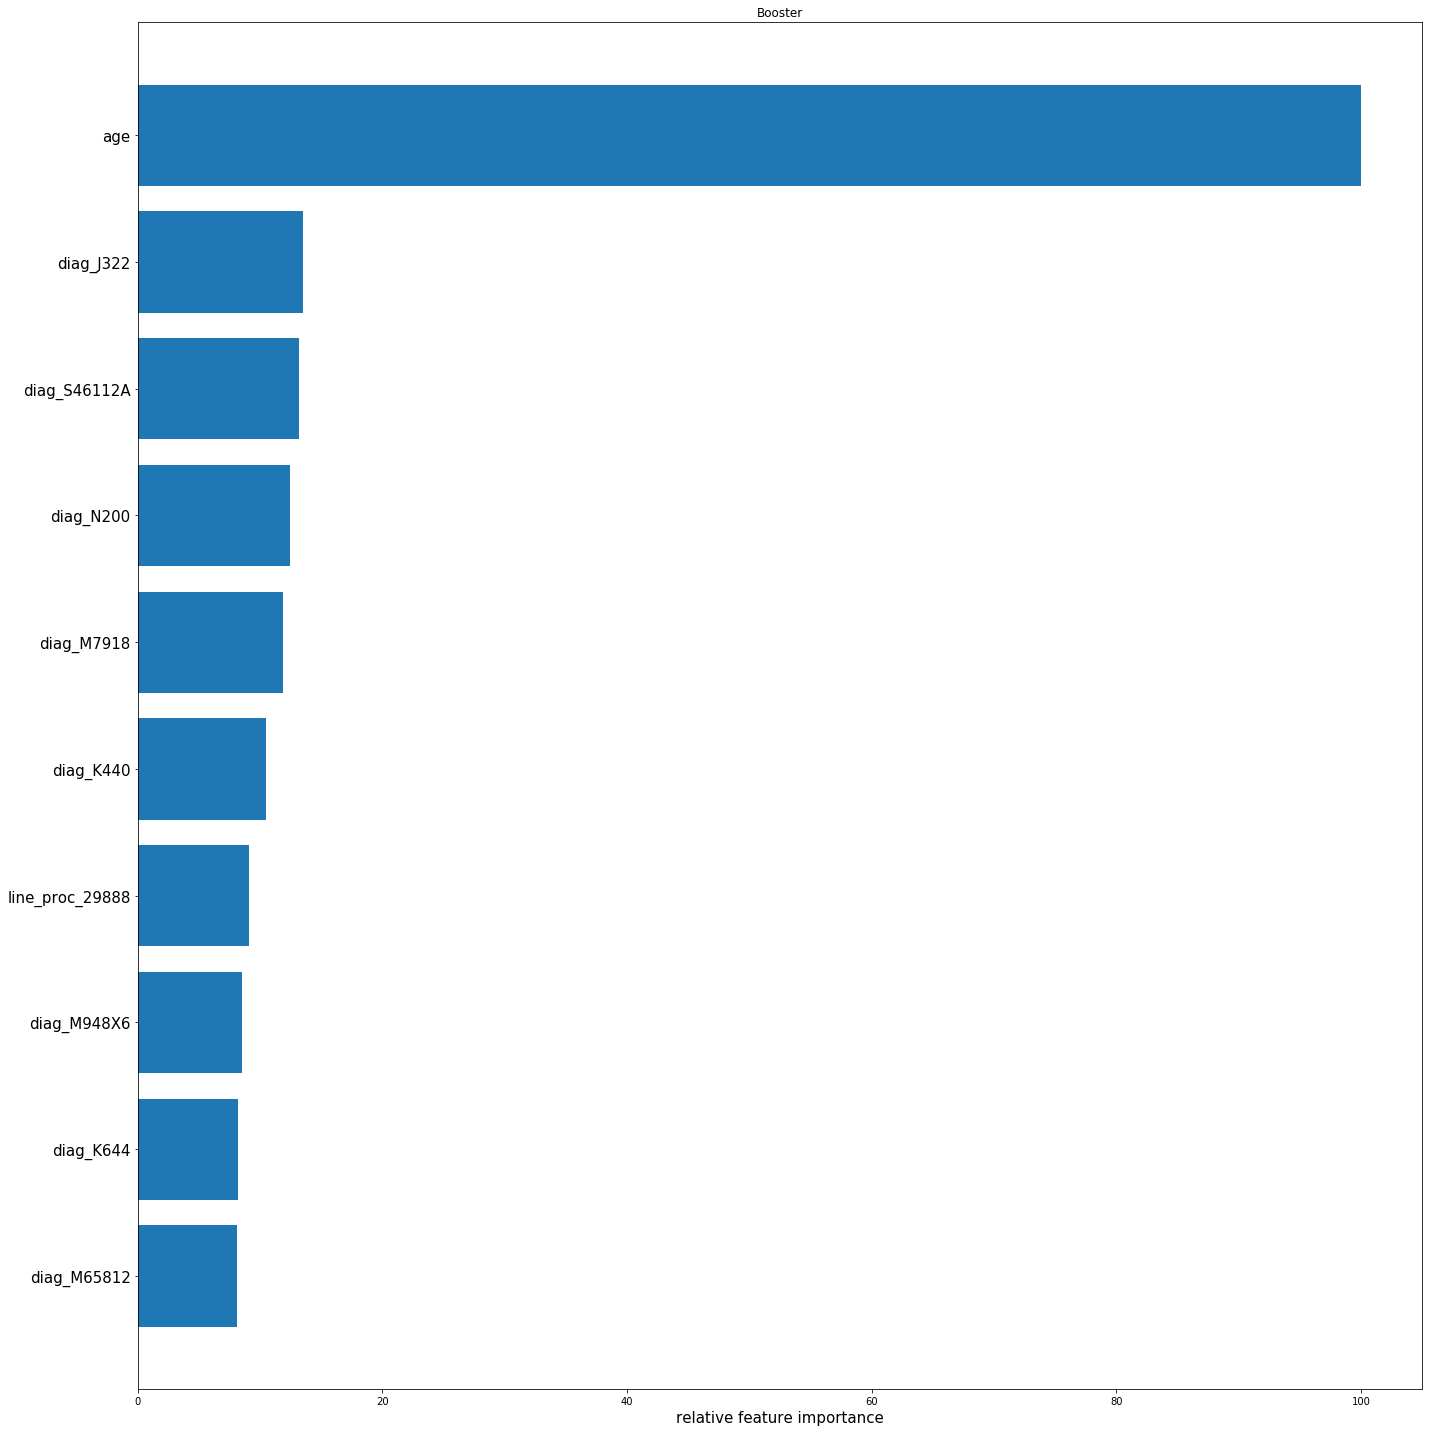

In [29]:
feature_lst = dv1.get_feature_names() + dv2.get_feature_names() + dv3.get_feature_names()
feature_rank_plot(reg, 10, feature_lst, 'gain')